See Yirang Liu for questions

In [1]:
# load packages
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data # 14 regions, threshold 35
df = pd.read_csv('https://github.com/ISL-0111/IDS701_Team_Project/raw/refs'
'/heads/main/Experiment_regression/daily_agg_for_ttest_14regions_log_threshold_35.csv')
df['high_load'] = df['high_load'].astype(int)
df.sample(2)

,courier_id,accept_date,region_id,task_count,avg_delivery_duration_min,avg_distance_km,delivery_hour_mode,high_load,task_count_c,hour_bin,log_duration
7859,1540,2023-06-30,77,9,133.888889,2.682063,9,0,-26,Morning,4.897010
16389,2812,2023-09-30,71,26,95.000000,0.816478,11,0,-9,Morning,4.553877


In [3]:
# Define target group
group_0 = df[df['high_load'] == 0]
group_1 = df[df['high_load'] == 1]

# Get numeric columns excluding 'high_load'
numeric_cols = df.select_dtypes(include='number').columns.drop(
    'high_load')

In [4]:
# Run t-tests
results = []
for col in numeric_cols:
    g0 = group_0[col].dropna()
    g1 = group_1[col].dropna()
    if len(g0) < 2 or len(g1) < 2:
        continue
    t_stat, p_val = ttest_ind(g0, g1, equal_var=False)
    results.append((col, t_stat, p_val))

In [5]:
results

[('courier_id', -1.6578853916686003, 0.09736840603612971),
 ('region_id', 13.587680817385788, 9.884895102279685e-42),
 ('task_count', -239.96951804124882, 0.0),
 ('avg_delivery_duration_min', 27.578806919868033, 2.134031582427143e-164),
 ('avg_distance_km', 3.314117347460808, 0.0009208923174949954),
 ('delivery_hour_mode', -5.20722010865359, 1.9498340000833487e-07),
 ('task_count_c', -239.96951804124882, 0.0),
 ('log_duration', 16.80203868822414, 7.653521156783919e-63)]

In [7]:
# Create DataFrame
results_df = pd.DataFrame(results, columns=[
    'Feature', 'T-statistic', 'P-value'])

# Avoid log10(0) by adding a really small number
epsilon = 1e-300
results_df['-log10(P-value)'] = -np.log10(results_df['P-value'] 
                                          + epsilon)

# Sort for plot
results_df.sort_values('-log10(P-value)', ascending=False, inplace=True)
results_df

,Feature,T-statistic,P-value,-log10(P-value)
2,task_count,-239.969518,0.000000e+00,300.000000
6,task_count_c,-239.969518,0.000000e+00,300.000000
3,avg_delivery_duration_min,27.578807,2.134032e-164,163.670799
7,log_duration,16.802039,7.653521e-63,62.116139
1,region_id,13.587681,9.884895e-42,41.005028
5,delivery_hour_mode,-5.207220,1.949834e-07,6.710002
4,avg_distance_km,3.314117,9.208923e-04,3.035791
0,courier_id,-1.657885,9.736841e-02,1.011582


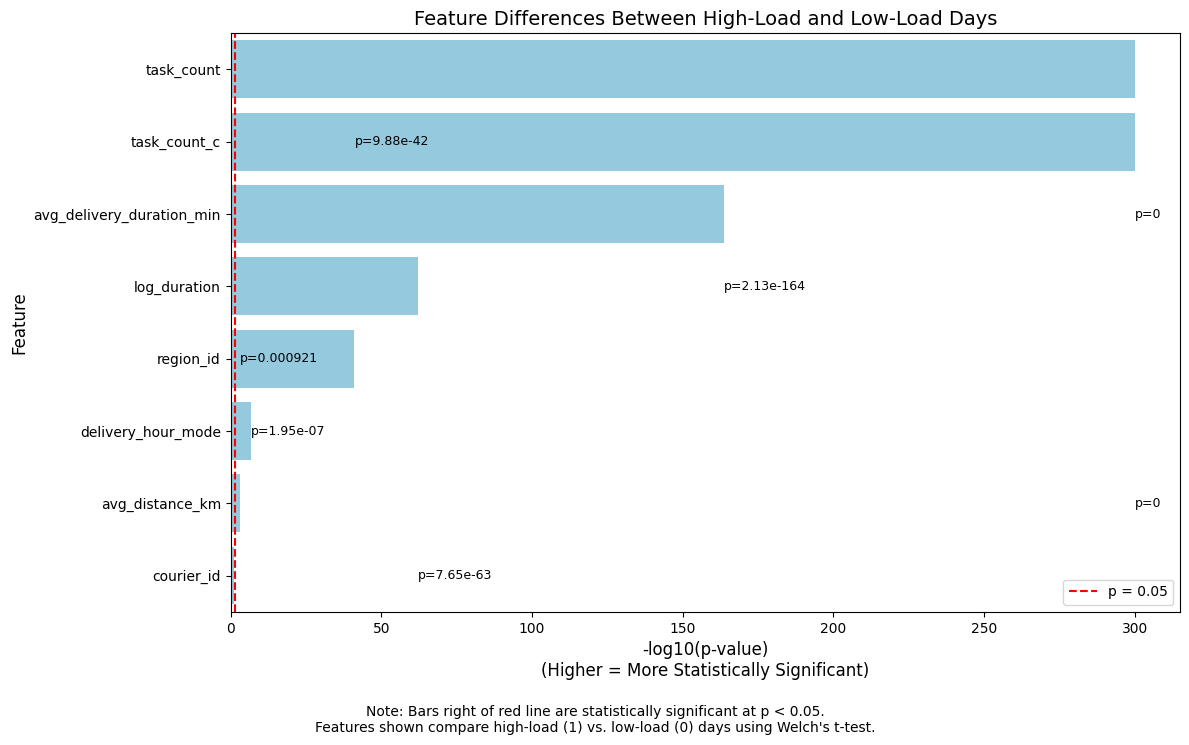

In [8]:
# --- Plot ---
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=results_df,
    x='-log10(P-value)',
    y='Feature',
    color='skyblue'
)

# Significance threshold line (p = 0.05)
sig_threshold = -np.log10(0.05)
plt.axvline(sig_threshold, color='red', linestyle='--', label='p = 0.05')

# Annotate bars
for i, row in results_df.iterrows():
    if row['-log10(P-value)'] > sig_threshold:
        ax.text(
            row['-log10(P-value)'] + 0.05, i,
            f"p={row['P-value']:.3g}",
            va='center',
            fontsize=9,
            color='black'
        )

# Labels and legend
plt.title('Feature Differences Between High-Load and Low-Load Days', 
          fontsize=14)
plt.xlabel('-log10(p-value)\n(Higher = More Statistically Significant)', 
           fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.legend(loc='lower right')

# Caption
plt.figtext(
    0.5, -0.05,
    "Note: Bars right of red line are statistically significant at p < 0.05.\n"
    "Features shown compare high-load (1) vs. low-load (0) days using Welch's t-test.",
    wrap=True,
    horizontalalignment='center',
    fontsize=10
)

plt.tight_layout()
plt.show()

In [10]:
# --- Effect size summary ---
summary = []
for col in results_df['Feature']:
    mean_0 = group_0[col].mean()
    mean_1 = group_1[col].mean()
    pct_diff = ((mean_1 - mean_0) / abs(mean_0)
                ) * 100 if mean_0 != 0 else float('nan')
    p_val = results_df.loc[results_df['Feature'] == col, 'P-value'
                           ].values[0]
    
    summary.append({
        'Feature': col,
        'Low Load Mean': mean_0,
        'High Load Mean': mean_1,
        '% Difference': pct_diff,
        'P-value': p_val
    })

summary_df = pd.DataFrame(summary)
summary_df = summary_df.round({
    'Low Load Mean': 2,
    'High Load Mean': 2,
    '% Difference': 1,
    'P-value': 4
})

# Show the effect size summary
print("\nEffect Size Summary:")
print(summary_df.sort_values('P-value'))


Effect Size Summary:
                     Feature  Low Load Mean  High Load Mean  % Difference  \
0                 task_count          17.83           42.96         140.9   
1               task_count_c         -17.17            7.96         146.3   
2  avg_delivery_duration_min         119.96           95.17         -20.7   
3               log_duration           4.56            4.45          -2.6   
4                  region_id          49.29           44.00         -10.7   
5         delivery_hour_mode          12.11           12.37           2.1   
6            avg_distance_km           3.35            2.51         -25.1   
7                 courier_id        2425.97         2458.20           1.3   

   P-value  
0   0.0000  
1   0.0000  
2   0.0000  
3   0.0000  
4   0.0000  
5   0.0000  
6   0.0009  
7   0.0974  


# Analysis Summary: Impact of High Load on Delivery Metrics (Updated)

A series of Welch’s t-tests were conducted to compare courier performance metrics between high-load and low-load days. The analysis revealed that several key features significantly differ when the system experiences heavy demand.

Most notably, task count per courier surged by approximately **141%** on high-load days, highlighting the substantial increase in operational pressure. Correspondingly, the variability in task counts (**task_count_c**) showed a similar dramatic rise of **146%**, indicating greater inconsistency in workload distribution across couriers. Interestingly, despite the higher task volume, the average delivery duration decreased by nearly **21%**, suggesting that couriers completed deliveries more quickly when the system was under strain.

Other significant but less pronounced differences were observed in **region_id** (**−10.7%**) and **delivery_hour_mode** (**+2.1%**), implying slight shifts in where and when deliveries occurred during high-load periods. Notably, average delivery distance decreased significantly by **25.1%**, suggesting that couriers traveled slightly shorter routes, perhaps due to operational optimizations. In contrast, courier identity remained statistically unchanged, indicating that workforce composition was stable.

These findings suggest that during high-load events, couriers adapt by accelerating deliveries while simultaneously optimizing travel distances, potentially through route batching, prioritization, or clustering of tasks.

## Result Summary
- **Statistically Significant Features (p < 0.05):**
  - **task_count** (**+140.9%** on high-load days)
  - **avg_delivery_duration_min** (**−20.7%**)
  - **task_count_c** (**+146.3%**)
  - **log_duration** (**−2.6%**)
  - **region_id** (**−10.7%**)
  - **delivery_hour_mode** (**+2.1%**)
  - **avg_distance_km** (**−25.1%**)
- **Not Significant:**
  - **courier_id** (p = 0.0974)

- **Strongest effects:**
  - Task volume (**task_count**) and task variance (**task_count_c**) surged under high load.
  - Delivery time decreased significantly (~21% faster deliveries).
  - Travel distance (**avg_distance_km**) also shortened significantly (~25% shorter).

## Interpretation
- **Operational Pressure leads to:**
  - Higher task volume handled per courier.
  - Shorter delivery durations — possibly due to operational optimizations like batching or re-routing.
  - Shorter delivery distances — suggesting improved route efficiency.
- **Workforce composition** (courier identity) remains stable.
- **Practical meaning:**
  - Couriers not only deliver faster but may also optimize their routes during high-load periods.
  - Minor regional and time-of-day shifts observed but not drastic.

## Proposals for Implementation
- **Dynamic Task Allocation:**
  - Auto-adjust courier assignments based on predicted load to maintain quality.
- **Incentivize Efficient Behavior:**
  - Performance gains under pressure suggest incentives can further boost efficiency during high load.
- **Regional Load Balancing:**
  - Monitor slight shifts in region usage and proactively rebalance couriers when necessary.

## Future Work
- **Predictive Modeling:**
  - Build a model to predict high-load days early using upstream signals (e.g., orders booked, customer activity).
- **Further Segmentation:**
  - Analyze patterns across **hour_bin** and weekday/weekend splits.
- **Explore Causality:**
  - Conduct controlled A/B experiments to validate whether proactive shift optimization further improves KPIs.
- **Investigate Courier Behavior:**
  - Study whether faster deliveries result from increased speed, better bundling, or smarter routing strategies.
